# Template

In [1]:
import matplotlib
import random

from collections import deque, namedtuple
from itertools import count
from time import time

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as utils
import torch.optim as optim
import pandas as pd

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [2]:
device_name = "cpu"

if False:
    if torch.cuda.is_available():
        device_name = "cuda"
    elif torch.mps.is_available():
        device_name = "mps"
    # elif torch.hip.is_available():
    #     device_name = "hip"
    elif torch.mtia.is_available():
        device_name = "mtia"
    elif torch.xpu.is_available():
        device_name = "xpu"

device = torch.device(device_name)
print(f"device: {device_name}")

device: cpu


## Process data

In [3]:
import sys
sys.path.append("/Users/toshi_pro/Documents/github-sub/machine-learning")
# sys.path.append(r"C:\Users\takat\PycharmProjects\machine-learning")

import flowdata
import flowenv

raw_data_train, raw_data_test = flowdata.flow_data.using_data()

# train_env = gym.make("flowenv/FlowTrain-v0", data=raw_data_train)
train_env = gym.make("flowenv/Flow-v1", data=raw_data_train)
# test_env = gym.make("flowenv/FlowTest-v0", data=raw_data_test)
test_env = gym.make("flowenv/Flow-v1", data=raw_data_test)

## Memory

In [4]:
Transaction = namedtuple('Transaction', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        # self.capacity = capacity
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transaction(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Plot rewards

In [5]:
def plot_rewards(rewards: list, show_result=False):
    plt.figure(figsize=(15,4))
    # durations_t = torch.tensor(episode_durations, dtype=torch.float)

    if show_result:
        plt.title("Result")
    else:
        plt.clf()
        plt.title("Training...")
    means = [rewards[0]]
    for i in range(1, len(rewards)):
        means.append(np.mean(rewards[0:i]))

    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(rewards)
    plt.plot(means, color="red")
    plt.grid()

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Plot Metrics

In [6]:
def plot_metrics(metrics_dict: dict, show_result=False):
    fig = plt.figure(figsize=(16, 10))

    ac = fig.add_subplot(3, 2, 1)
    ac.plot(metrics_dict["accuracy"], label="accuracy")
    ac.grid()
    ac.set_title("Accuracy")

    pr = fig.add_subplot(3, 2, 2)
    pr.plot(metrics_dict["precision"], label="precision", color="green")
    pr.grid()
    pr.set_title("Precision")

    re = fig.add_subplot(3, 2, 3)
    re.plot(metrics_dict["recall"], label="recall", color="red")
    re.grid()
    re.set_title("Recall")

    f1 = fig.add_subplot(3, 2, 4)
    f1.plot(metrics_dict["f1"], label="f1", color="black")
    f1.grid()
    f1.set_title("F1")

    fpr = fig.add_subplot(3, 2, 5)
    fpr.plot(metrics_dict["fpr"], label="fpr", color="purple")
    fpr.grid()
    fpr.set_title("FPR")

    plt.tight_layout()
    plt.pause(0.01)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def plot_metrics_one(metrics_dict: dict, show_result=False):
    plt.figure(figsize=(16, 5))

    plt.plot(metrics_dict["accuracy"], label="accuracy")
    plt.plot(metrics_dict["precision"], label="precision", color="green")
    plt.plot(metrics_dict["recall"], label="recall", color="red")
    plt.plot(metrics_dict["f1"], label="f1", color="black")
    plt.plot(metrics_dict["fpr"], label="fpr", color="purple")
    
    plt.pause(0.01)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def calculate_metrics(tp, tn, fp, fn):
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp) if tp + fp != 0 else -1
    recall = tp / (tp + fn) if tp + fn != 0 else -1
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0.0
    fpr = fp / (fp + tn) if fp + tn != 0 else 0.0

    if precision < 0:
        precision = 0.0
    if recall < 0:
        recall = 0.0
    return accuracy, precision, recall, f1, fpr

## Network

In [7]:
class DuelingDQNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DuelingDQNetwork, self).__init__()
        self.shared_layer = nn.Sequential(
            nn.Linear(n_inputs, 128),
            nn.ReLU()
        )
        self.advantage = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_outputs)
        )
        self.value = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        shared = self.shared_layer(x)
        advantage = self.advantage(shared)
        value = self.value(shared)
        return value + advantage - advantage.mean(dim=1, keepdim=True)

## Constants

In [8]:
UPDATE_TARGET_STEPS = 200
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 10000
TAU = 0.005
LR = 1e-5

## Variables

In [9]:
num_episodes = 1000

n_inputs = train_env.observation_space.shape[0]
n_outputs = train_env.action_space.n

policy_net = DuelingDQNetwork(n_inputs, n_outputs).to(device)
target_net = DuelingDQNetwork(n_inputs, n_outputs).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=LR)

steps_done = 0

memory = ReplayMemory(10000)
episode_rewards = []
episode_precision = []
episode_metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "fpr": []
}

## Functions

In [10]:
def select_action(state: torch.Tensor):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)

    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randrange(train_env.action_space.n)]], device=device, dtype=torch.long)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transactions = memory.sample(BATCH_SIZE)
    batch = Transaction(*zip(*transactions))

    states_batch = torch.cat(batch.state)
    actions_batch = torch.cat(batch.action)
    rewards_batch = torch.cat(batch.reward)
    next_states_batch = torch.cat(batch.next_state)

    # print(states_batch.dim(), actions_batch.dim())
    q_values = policy_net(states_batch).gather(1, actions_batch)

    with torch.no_grad():
        next_actions = policy_net(next_states_batch).argmax(dim=1, keepdim=True)
        next_q_values = target_net(next_states_batch).gather(1, next_actions)
    
    target_q_values = rewards_batch + GAMMA * next_q_values
    target_q_values = torch.mean(target_q_values, dim=1, keepdim=True)

    # print(q_values.shape, target_q_values.shape)
    # print(target_q_values.shape, buf.shape)
    
    loss = nn.functional.mse_loss(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [11]:
def confusion_to_metrics(matrix):
    tp = matrix[0, 0]
    fn = matrix[0, 1]
    fp = matrix[1, 0]
    tn = matrix[1, 1]

    return calculate_metrics(tp, tn, fp, fn)


## Main loop

In [12]:
num_episodes = 10000

In [13]:
def test():
    device = torch.device("cpu")
    MODEL_PATH = "d3qn_no4.pth"

    # load the model
    trained_network = DuelingDQNetwork(n_inputs, n_outputs)
    trained_network.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=True))
    trained_network.eval()

    # test the model

    confusion_array = np.zeros((2, 2), dtype=np.int32)
    metrics_dictionary = {
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "fpr": []
    }

    for i_loop in range(100):
        test_raw_state, _ = test_env.reset()
        test_state = torch.tensor(test_raw_state, device=device, dtype=torch.float32).unsqueeze(0)

        for t in count():
            with torch.no_grad():
                test_action = trained_network(test_state).max(1).indices.view(1, 1)

            test_raw_next_state, test_reward, test_terminated, test_truncated, test_info = test_env.step(test_action.item())

            # calculate confusion matrix
            raw = 0 if test_reward == 1 else 1

            # test_info = (row, column) means confusion matrix index
            index = test_info["confusion_position"]
            confusion_array[index[0], index[1]] += 1

            if test_terminated:
                break

            # make next state tensor and update state
            test_state = torch.tensor(test_raw_next_state, device=device, dtype=torch.float32).unsqueeze(0)

        # calculate metrics
        tp = confusion_array[0, 0]
        tn = confusion_array[1, 1]
        fp = confusion_array[0, 1]
        fn = confusion_array[1, 0]

        accuracy, precision, recall, f1, fpr = calculate_metrics(tp, tn, fp, fn)
        metrics_dictionary["accuracy"].append(accuracy)
        metrics_dictionary["precision"].append(precision)
        metrics_dictionary["recall"].append(recall)
        metrics_dictionary["f1"].append(f1)
        metrics_dictionary["fpr"].append(fpr)

    return [np.mean(metrics_dictionary["accuracy"]), np.mean(metrics_dictionary["precision"]), np.mean(metrics_dictionary["recall"]), np.mean(metrics_dictionary["f1"]), np.mean(metrics_dictionary["fpr"])]

<Figure size 640x480 with 0 Axes>

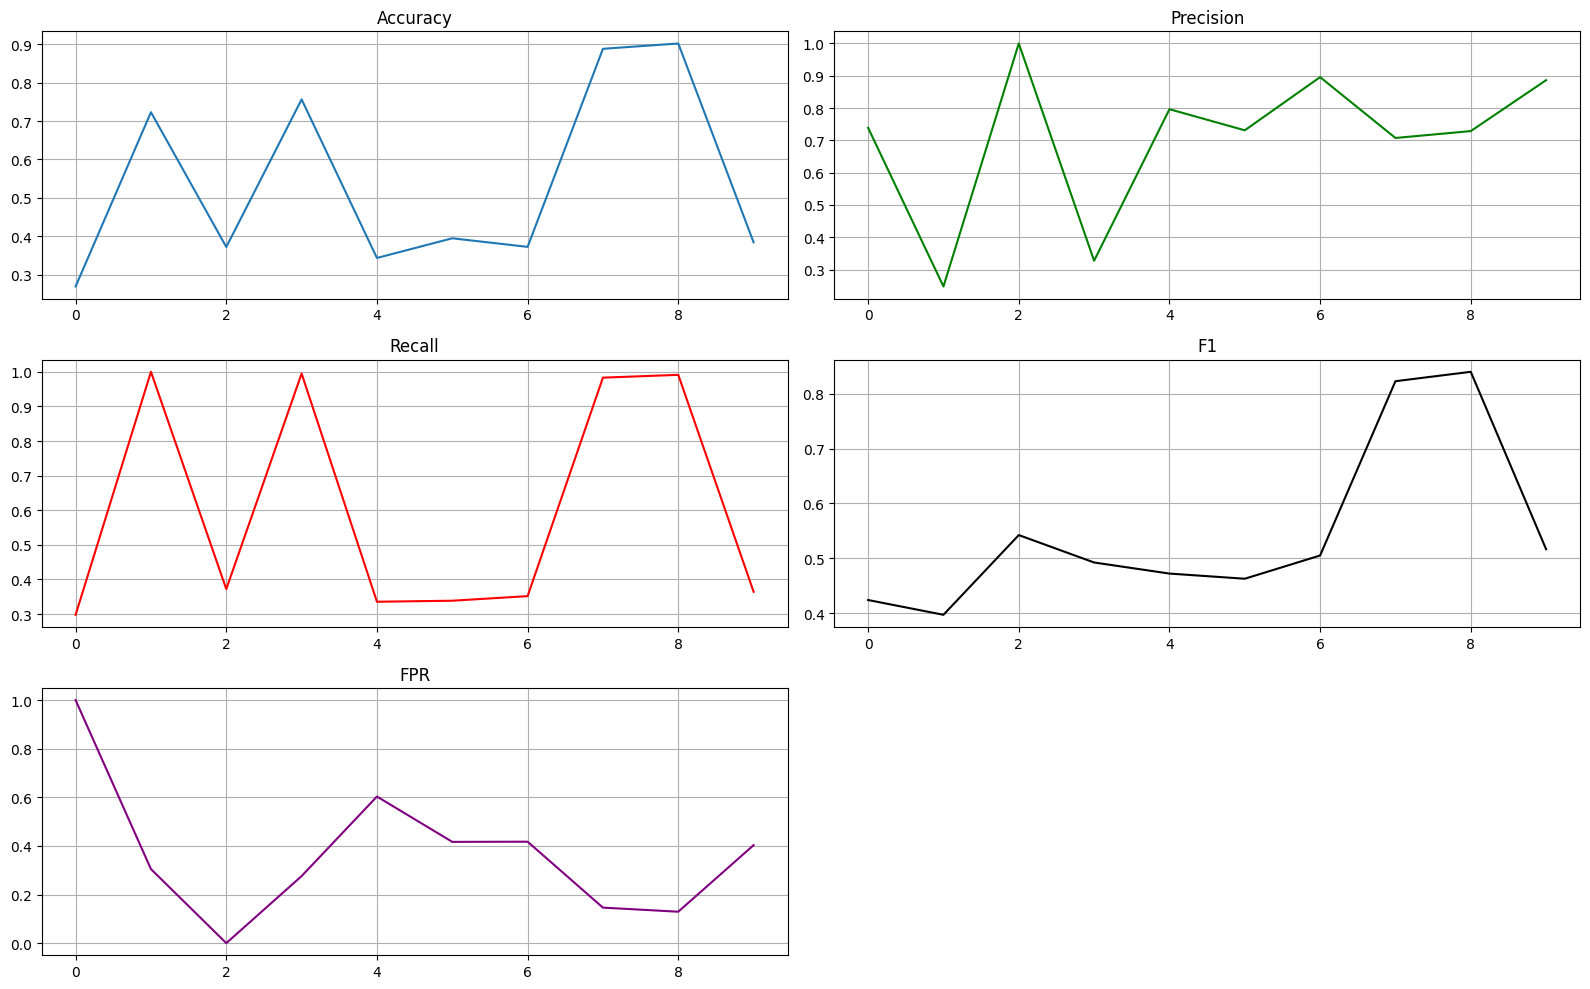

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

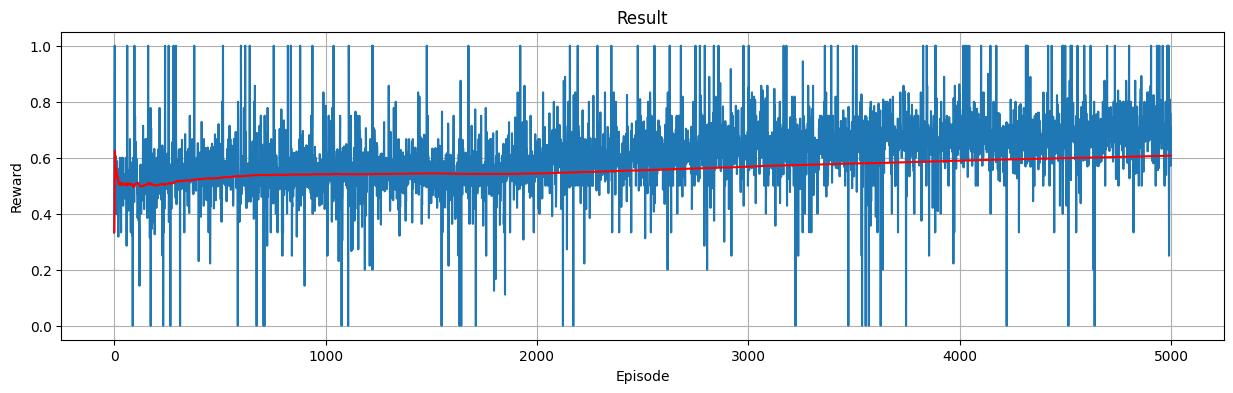

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [14]:
counter = 0
for i_episode in range(num_episodes):
    # Initialize the environment and state
    sum_reward = 0
    confusion_matrix = np.zeros((2,2), dtype=int)


    initial_state, info = train_env.reset()
    state = torch.tensor(initial_state, device=device, dtype=torch.float32).unsqueeze(0)

    for t in count():
        # select action
        action = select_action(state)

        # calculate next state
        raw_next_state, reward, terminated, truncated, info = train_env.step(action.item())
        row_column_index = info["confusion_position"]
        confusion_matrix[row_column_index[0], row_column_index[1]] += 1

        # to tensor
        #if terminated:
        #   next_state = None
        #else:
        next_state = torch.tensor(raw_next_state, device=device, dtype=torch.float32).unsqueeze(0)
        reward = torch.tensor([reward], device=device, dtype=torch.float32)

        # store the transition in memory
        memory.push(state, action, next_state, reward)
        sum_reward += reward.item() if reward.item() == 1 else 0

        # move to the next state
        state = next_state

        # optimize the model
        optimize_model()

        # update the target network
        if steps_done % UPDATE_TARGET_STEPS == 0:
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in target_net_state_dict:
                target_net_state_dict[key] = TAU * policy_net_state_dict[key] + (1 - TAU) * target_net_state_dict[key]
            target_net.load_state_dict(target_net_state_dict)

        if terminated:
            episode_rewards.append(sum_reward / (t + 1))
            break

    # do after the episode
    # episode_rewards.append(sum_reward)
    base = confusion_matrix[0, 0] + confusion_matrix[1, 0]
    episode_precision.append(
        confusion_matrix[0,0] / base if base != 0 else None
    )
    if i_episode % 500 == 0:
        torch.save(policy_net.state_dict(), "d3qn_no4.pth")  # save the model

        print(f"Episode {i_episode}: {sum_reward}")
        ac, pr, re, f1, fp = test()
        episode_metrics["accuracy"].append(ac)
        episode_metrics["precision"].append(pr)
        episode_metrics["recall"].append(re)
        episode_metrics["f1"].append(f1)
        episode_metrics["fpr"].append(fp)
        plot_metrics(episode_metrics)
else:
    torch.save(policy_net.state_dict(), "d3qn_no4.pth")  # save the model

    print(f"Episode {i_episode}: {sum_reward}")
    ac, pr, re, f1, fp = test()
    episode_metrics["accuracy"].append(ac)
    episode_metrics["precision"].append(pr)
    episode_metrics["recall"].append(re)
    episode_metrics["f1"].append(f1)
    episode_metrics["fpr"].append(fp)

# complete the episode
plot_metrics(episode_metrics, show_result=True)
plot_rewards(episode_rewards, show_result=True)

train_env.close()

In [15]:
print(len(episode_rewards))

5000


## Test the model

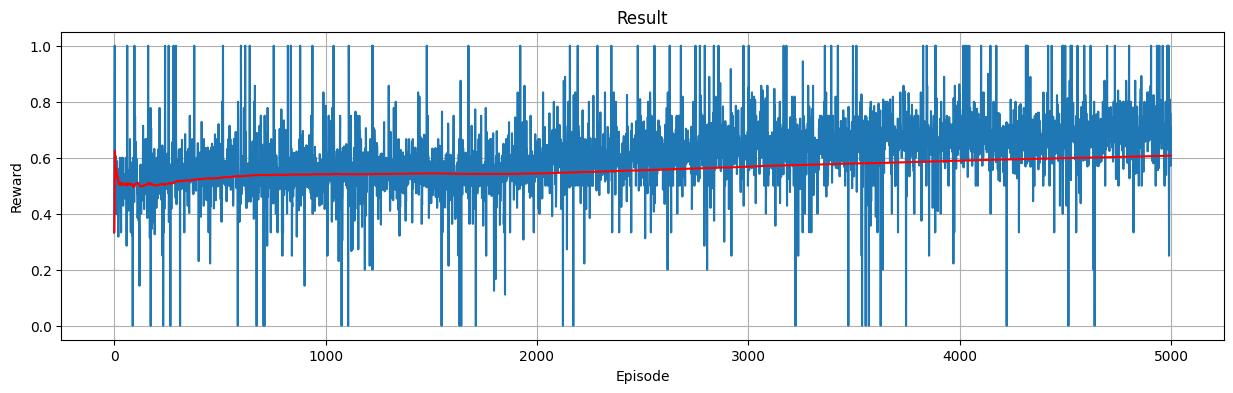

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
plot_rewards(episode_rewards, show_result=True)
torch.save(policy_net.state_dict(), "d3qn_no4.pth")  # save the model

In [20]:
print(episode_metrics

KeyError: 8